In [1]:
from astropy.io import fits
from astropy.stats import biweight_location as bil
import numpy as np
from scipy import interpolate
import statistics
import datetime
import time
from time import strptime
import random
import math
from matplotlib import pyplot as plt

import glob

In [2]:
def linlin(x, fluxv, start, step, stop=0., dowarn=True):
        """lin_rebin(x, flux, start, stop=0, step)
        Performs linear rebinning of arbitrarely sampled input spectra.
        x an array of input wavelengths in angstrom
        flux and array of fluxes in arbitrary untis
        start start wavelength in A
        stop (optional stop wavelength in A)
        step in km/s   
        function function for rebinning. Note for lin to log binning, "exp" has to be given, for 
                log to lin binning "log" has to be given!
        """
        
        warned = ~dowarn

        # make sure the array are sorted in ascending order     
        ii = np.argsort(x)
        x = x[ii]
        fluxv = fluxv[ii]
        
        if stop == 0. or stop > x[-1]:
                stop = x[-1]

        # prepare pix(wavelength) interpolation class   
        n1 = interpolate.interp1d( x, np.arange(x.shape[0]), 'linear', bounds_error=False)
        
        #output
        out = []
        
        # do the interpolation here, just one, this speeds the whole process up
        nmax = (stop - -start - step/2.)/step
        aalam  = np.arange(nmax+1)*step + start
        aalam1 = aalam + (-step/2.)
        aalam2 = aalam + (+step/2.)
        
        xx1  = n1(aalam1)
        xx2  = n1(aalam2)

        n = -1
        while True:
                # calculate current window size 
                n += 1
                #print "alam = %f + %f - %f " % (alam, alam1, alam2)
                #end while-loop if end of input range is reached
                #print(n)
                #print(aalam2)
                if aalam2[n] > stop:
                        break

                if aalam1[n] < x[0]:
                        out.append(0)
                        continue
                #tanslate wavelengths into pixel indices through linear interpolation
                x1  = xx1[n]
                x2  = xx2[n]
                mx1 = int( np.floor(x1) )
                mx2 = int( np.floor(x2) )
                if (x1 <= 0.) :
                        mx1 = 0
                if (x2 >= len(x)):
                        mx2 = len(x)-2
                # first integrate over all pixel which are fully contained in the
                #  current interval, integrate piecewise from the 
                #  center of on pixel to the next (therefore (pixel_i + pixel_(i+1))/2.)
                #
                flx=0.
                for ipix in range(int( mx1+1),int(mx2-1 + 1)):
                        flx=flx+( fluxv[ipix] + fluxv[ipix+1] )/2.
                
                # Now take care of the edges of the current interval using the
                # trapezium rule
                if (x1 < 0.):
                        x1 = 0.

                if (x2 > len(x)-1 ):
                         x2 = len(x)-1
                
                if mx1 < mx2:
                        a1 = fluxv[mx1+1]-fluxv[mx1]
                        b1 = fluxv[mx1]
                        f_prime1 = a1*(x1-mx1) + b1
                        flx1 = (mx1+1-x1) * (f_prime1 + fluxv[mx1+1])/2.
                        
                        a2 = fluxv[mx2+1]-fluxv[mx2]
                        b2 = fluxv[mx2]
                        f_prime2 = a2*(x2 - mx2) + b2
                        flx2 = (x2-mx2) * ( f_prime2 + fluxv[mx2] )/2.
                elif mx1 == mx2:
                        if not warned:
                                print ("Warning: Such a small step width leads to sub pixel bins.")
                                warned = True                   
                        a1 = fluxv[mx1+1]-fluxv[mx1]
                        b1 = fluxv[mx1]
                        f_prime1 = a1*(x1-mx1) + b1
                        f_prime2 = a1*(x2-mx1) + b1
                        flx1 = (x2-x1) * (f_prime1+f_prime2)/2.
                        flx2 = 0.
                else:
                        print("Error mx1 > mx2, should never happen!")

                out.append(flx + flx1 + flx2)
        out_xs = np.arange(len(out))*step + (start)        

        return out_xs, np.array(out)
    
def bootstrap(data_set,n_bootstraps):

    global stat_bootstrap
    stat_bootstrap = list()

    for k in range(n_bootstraps):

        ind = list()
        resample_data = list()

        for i in range(len(data_set)):
            num = random.randint(0,len(data_set)-1)
            ind.append(num)

        for j in ind:
            resample = data_set[j]
            resample_data.append(resample)

        resample_mean = bil(resample_data)
        if math.isnan(resample_mean):
            resample_mean = np.mean(resample_data)
        stat_bootstrap.append(resample_mean)
        
    return stat_bootstrap

def multifits_output_error(multifiles, step=2):
    
    '''This version is designed to be used with multifits files, where the sky spectrum has
    previously been reduced and cleaned. It is also desigened to be used with an accompanying program ifu_comparison,
    and creates global variables to be used there. By default, this program does not create any output.'''
           
    '''This section pulls data from the multifits files, and puts them into dictionaries.
    The times the exposures were taken are also collected here.'''
    
    file_list = dict()
    data_list = dict()
    wavelength_list = dict()
    
    times = set([])
    
    for alpha in multifiles:
        hdul = fits.open(alpha)
        file_list[alpha] = [hdul[0].header['IFUSLOT'],
                            hdul[0].header['CCDPOS'],
                            hdul[0].header['CCDHALF'],
                            hdul[0].header['UT']]
        data_list[alpha] = [hdul['spectrum'].data]
        wavelength_list[alpha] = [hdul['wavelength'].data]
        times.add(file_list[alpha][3])
        hdul.close()

    times = sorted(times)

    time_values = set([])

    for delta in range(len(times)):
        time_break = strptime(times[delta].split('.')[0],'%H:%M:%S')
        time_values.add(
            datetime.timedelta(
                hours=time_break.tm_hour,
                minutes=time_break.tm_min,
                seconds=time_break.tm_sec).total_seconds())
    
    time_values = sorted(time_values)
    
    matrix_values = [[[0 for z in range(len(times))]
                       for x in range(10)]
                      for y in range(10)]
    
    min_error_matrix = [[[0 for z in range(len(times))]
                        for x in range(10)]
                       for y in range(10)]
    
    max_error_matrix = [[[0 for z in range(len(times))]
                        for x in range(10)]
                       for y in range(10)]
    
    errors = [[[0 for z in range(len(times))]
                        for x in range(10)]
                       for y in range(10)]
    
    '''Here we straighten the data sets, so that each is aligned by wavelength'''
    
    for x in data_list:
        wl = wavelength_list[x][0]
        fl = data_list[x][0]
        
        data = []
        
        for i in range(wl.shape[0]):
            w = wl[i,:]
            f = fl[i,:]
            start = statistics.median(wl[:,0])
            step = step
            stop = min(wl[:,-1])
            lw, lf = linlin(w, f, start, step, stop, dowarn=False)
            data.append(lf/step)
        
        data_list[x] = data
    
    '''This section actually calculates output.'''
    
    '''We start by creating blank matrices.'''
    
    for beta in times:    
        w, h = 10, 10;
        llmatrix = [[0 for x in range(w)] for y in range(h)]
        lumatrix = [[0 for x in range(w)] for y in range(h)]
        rlmatrix = [[0 for x in range(w)] for y in range(h)]
        rumatrix = [[0 for x in range(w)] for y in range(h)]
        ll_min_error = [[0 for x in range(w)] for y in range(h)]
        lu_min_error = [[0 for x in range(w)] for y in range(h)]
        rl_min_error = [[0 for x in range(w)] for y in range(h)]
        ru_min_error = [[0 for x in range(w)] for y in range(h)]
        ll_max_error = [[0 for x in range(w)] for y in range(h)]
        lu_max_error = [[0 for x in range(w)] for y in range(h)]
        rl_max_error = [[0 for x in range(w)] for y in range(h)]
        ru_max_error = [[0 for x in range(w)] for y in range(h)]
        
        timestamp = list(enumerate(times))[times.index(beta)][0]

        '''Here we define the values unique to the file, using the dictionaries created above.'''
        
        for gamma in file_list:
            
            row = int(file_list[gamma][0][-1])
            column = int(file_list[gamma][0][:-1])-1
            side = file_list[gamma][1]
            position = file_list[gamma][2]
            time = file_list[gamma][3]
            
            '''We only continue if the time matches. Each file will be done, but to correlate
            the correct ones together, they are sorted by time.'''
            
            if time==beta:   
                out = bil(data_list[gamma])
                
                error = bootstrap(data_list[gamma],100)
                min_error = min(error)
                max_error = max(error)
                
                if side=='L':
                    if position=='L':
                        llmatrix[row][column] = out
                        ll_min_error[row][column] = min_error
                        ll_max_error[row][column] = max_error
                    if position=='U':
                        lumatrix[row][column] = out
                        lu_min_error[row][column] = min_error
                        lu_max_error[row][column] = max_error
                if side=='R':
                    if position=='L':
                        rlmatrix[row][column] = out
                        rl_min_error[row][column] = min_error
                        rl_max_error[row][column] = max_error
                    if position=='U':
                        rumatrix[row][column] = out
                        ru_min_error[row][column] = min_error
                        ru_max_error[row][column] = max_error                        

        '''The side matrices are averaged, for a final matrix. This is done for each time that
        data was taken, according to the list of times.'''
        
        """The errors are returned in the form where the first two indecies give the IFU, the third is for first lower
        errors, and then second upper erros, and finally the forth index gives the exposure. This is done to format well
        with the matplotlib.pyplot.errorbar function."""
                    
        for iota in range(10):
            for kappa in range(10):
                matrix_values[iota][kappa][timestamp] = np.mean(
                        [llmatrix[iota][kappa],lumatrix[iota][kappa],
                         rlmatrix[iota][kappa],rumatrix[iota][kappa]])
                min_error_matrix[iota][kappa][timestamp] = np.mean([
                    ll_min_error[iota][kappa],lu_min_error[iota][kappa],
                    rl_min_error[iota][kappa],ru_min_error[iota][kappa]])
                max_error_matrix[iota][kappa][timestamp] = np.mean([
                    ll_max_error[iota][kappa],lu_max_error[iota][kappa],
                    rl_max_error[iota][kappa],ru_max_error[iota][kappa]])
                
                y_err_min = np.subtract(matrix_values,min_error_matrix)
                y_err_max = np.subtract(max_error_matrix,matrix_values)
                errors[iota][kappa] = (y_err_min[iota][kappa],y_err_max[iota][kappa])
        
    return matrix_values,errors

def ifu_multi_compare(matrix,ifu_list,exp_list,ifu_compare,exp_compare):
    
    """This program can take multiple IFU and exposure numbers. The ifu_list and exp_list must be given as a list of
    strings. The comparative values are just given as strings, not lists."""
    
    """Currently the exposure numbers are being used in Python notation, which starts at 0. This means that if there are 
    three exposures in the data, a 0, 1, or 2 may be entered, represting the 1st, 2nd, and 3rd exposures respectively.
    This can be changed if desired by simply subtracting 1 from the exp and exp_compare lines below."""
    
    out_values = []
    
    number_compare = str(ifu_compare)
    row_compare = int(number_compare[2])
    column_compare = int(number_compare[0:2])-1
    exp_compare = int(exp_compare)
    
    for x in ifu_list:
        for y in exp_list:
            
            number = str(x)
            row = int(number[2])
            column = int(number[0:2])-1
            exp = int(y)
            
            output = matrix[row][column][exp]/matrix[row_compare][column_compare][exp_compare]
            
            out_values.append(output)
            
    return(out_values)

In [3]:
files_multi = glob.glob('Data/20180910/virus/virus0000012/exp0*/virus/multi*.fits')

In [4]:
matrix, errors = multifits_output_error(files_multi)

In [5]:
ifus = ['033','073','045','085','037']
exps = ['0',2]

ifu_multi_compare(matrix,ifus,exps,'045','0')

[0.93713969621812521,
 0.62063273711464462,
 0.86944166702727899,
 0.58204467209769462,
 1.0,
 0.66450240721554088,
 0.81648118826851557,
 0.54479421155775787,
 0.93877516447331422,
 0.61799133564841191]

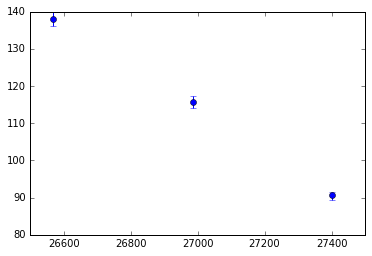

In [6]:
times = [26568.677, 26984.966, 27401.272]

plt.errorbar(times,matrix[3][1],yerr=errors[3][1],fmt='o')
plt.show()

In [7]:
errors[3][1]

(array([ 1.85942403,  1.62418078,  1.3334803 ]),
 array([ 2.05281065,  1.41683832,  0.96453442]))